In [339]:
import pandas as pd
import os 
import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import cross_validate, KFold, cross_val_predict
from sklearn.metrics import f1_score, accuracy_score, make_scorer, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm

## Predicting Drug Response Across CTRP Cell Lines

In [227]:
PATH = os.path.join('data', 'Data_Frames')

scores = {
    'drug': [], 
    'mse': [], 
    'explained_variance': [],
    'r2': [], 
    'accuracy': [],
    'f1': [],
    'roc_auc': []
}

# iterate over files
for file in os.listdir(PATH):
    f_path = os.path.join(PATH, file)
    print(file)
    
    # read data and separate label from features
    df = pd.read_csv(f_path, sep='\t')
    drug = df.pop('DRUG')[0]
    cell = df.pop('CELL')
    y = df.pop('AUC1')
    X = df
    
    scores['drug'].append(drug)
    
    # set regression and classification metrics
    regression_metrics = ['neg_mean_squared_error', 'explained_variance', 'r2']
    f1 = make_scorer(f1_score, average='weighted')
    roc_auc = make_scorer(roc_auc_score, average='weighted', multi_class='ovr')
    accuracy = make_scorer(accuracy_score)
    classification_metrics = {
        'accuracy': accuracy, 
        'f1': f1, 
        'roc_auc': roc_auc
    }
    
    # 5-fold cross validation
    kf = KFold(n_splits=5, random_state=1, shuffle=True)
    
    # Random Forest for regression
    rf_reg = RandomForestRegressor(n_jobs=-1)

    print('\t', 'regression')
    rf_reg_scores = cross_validate(rf_reg, X, y, scoring=regression_metrics, cv=kf, n_jobs=-1)
    
    scores['mse'].append(abs(rf_reg_scores['test_neg_mean_squared_error'].mean()))
    print('\t\t', scores['mse'][-1])
    scores['explained_variance'].append(abs(rf_reg_scores['test_explained_variance'].mean()))
    scores['r2'].append(abs(rf_reg_scores['test_r2'].mean()))
    
    # Random Forest for classification
    # first bin the data
    p33 = np.percentile(y, 33.33)
    p66 = np.percentile(y, 66.66)
    y_clf = []
    for i in y:
        if i <= p33:
            y_clf.append(np.array([1, 0, 0]))
        elif i > p66:
            y_clf.append(np.array([0, 0, 1]))
        else:
            y_clf.append(np.array([0, 1, 0]))
    y_clf = np.array(y_clf)
    
    rf_clf = RandomForestClassifier(n_jobs=-1)

    print('\t', 'classification')
    rf_clf_scores = cross_validate(rf_clf, X, y_clf, scoring=classification_metrics, cv=kf, n_jobs=-1)
    
    scores['accuracy'].append(abs(rf_clf_scores['test_accuracy'].mean()))
    print('\t\t', scores['accuracy'][-1])
    scores['f1'].append(abs(rf_clf_scores['test_f1'].mean()))
    scores['roc_auc'].append(abs(rf_clf_scores['test_roc_auc'].mean()))

df_drug.CTRP.470.tsv
	 regression
		 0.015581464507451407
	 classification
		 0.15012878524190743
df_drug.CTRP.464.tsv
	 regression
		 0.00116702527076529
	 classification
		 0.08837209302325581
df_drug.CTRP.101.tsv
	 regression
		 0.0008242954246633439
	 classification
		 0.1909274193548387
df_drug.CTRP.303.tsv
	 regression
		 0.004310306883051467
	 classification
		 0.06419686800894855
df_drug.CTRP.505.tsv
	 regression
		 0.002460192199592411
	 classification
		 0.0804040404040404
df_drug.CTRP.539.tsv
	 regression
		 0.0019241568026717257
	 classification
		 0.06685378241112001
df_drug.CTRP.51.tsv
	 regression
		 0.007212006148565759
	 classification
		 0.09359201773835919
df_drug.CTRP.7.tsv
	 regression
		 0.0014018432773208872
	 classification
		 0.0037735849056603774
df_drug.CTRP.472.tsv
	 regression
		 0.016461559005990518
	 classification
		 0.1350711938663746
df_drug.CTRP.91.tsv
	 regression
		 0.0016274552398170654
	 classification
		 0.06952380952380952
df_drug.CTRP.2.tsv
	 r

In [438]:
scores_df = pd.DataFrame(scores)
scores_df.sort_values('accuracy', ascending=False, inplace=True)

#### Top 10 drug effectiveness predictions of our model:

In [439]:
scores_df.head(10)

,drug,mse,explained_variance,r2,accuracy,f1,roc_auc
26,CTRP.343,0.016717,0.640055,0.639801,0.777343,0.846555,0.874436
32,CTRP.29,0.007654,0.666676,0.665944,0.731262,0.831998,0.859367
17,CTRP.33,0.007666,0.608662,0.601428,0.702619,0.808410,0.843090
18,CTRP.413,0.016808,0.314768,0.309059,0.328655,0.411767,0.624530
37,CTRP.487,0.003924,0.290277,0.279502,0.313411,0.398154,0.615797
28,CTRP.196,0.024207,0.444820,0.442441,0.277044,0.374733,0.611564
31,CTRP.193,0.005108,0.380117,0.374795,0.275628,0.362471,0.600456
23,CTRP.414,0.017959,0.439310,0.438591,0.275363,0.358947,0.608251
51,CTRP.441,0.020390,0.315903,0.310184,0.258680,0.340106,0.600170
40,CTRP.297,0.003340,0.163994,0.162778,0.223454,0.307724,0.580290


#### Bottom 10 drug effectiveness predictions of our model:

In [276]:
scores_df.tail(10)

,drug,mse,explained_variance,r2,accuracy,f1,roc_auc
3,CTRP.303,0.004310,0.043207,0.027557,0.064197,0.106970,0.513002
47,CTRP.244,0.003774,0.011811,0.004634,0.051355,0.087601,0.511256
14,CTRP.80,0.002694,0.274249,0.397323,0.050725,0.080283,0.507824
27,CTRP.155,0.001179,0.250994,0.846751,0.027619,0.026032,0.491861
48,CTRP.89,0.003041,0.043558,0.078920,0.027484,0.044046,0.498563
36,CTRP.323,0.002240,0.113111,0.143728,0.025755,0.043845,0.488474
29,CTRP.395,0.002402,0.042586,0.051351,0.023684,0.043803,0.504102
19,CTRP.163,0.005408,0.661287,0.851068,0.015611,0.028017,0.497023
38,CTRP.64,0.001445,0.049857,0.252130,0.014286,0.019048,0.461854
7,CTRP.7,0.001402,0.044789,0.063338,0.003774,0.006753,0.489441


## Ranking Most Effective Drugs by Cell Line

In [343]:
# iterate over files
dfs = []
for file in tqdm(os.listdir(PATH)):
    f_path = os.path.join(PATH, file)
    df = pd.read_csv(f_path, sep='\t')
    dfs.append(df)
df_all = pd.concat(dfs, ignore_index=True)

100%|██████████| 53/53 [00:05<00:00,  9.02it/s]


In [349]:
enc = OneHotEncoder()
oh = enc.fit_transform(np.array(df_all.DRUG).reshape(-1, 1))
df_all = pd.concat([df_all, pd.DataFrame(oh.toarray())], axis=1)
y = df_all['AUC1']
X = df_all.drop(['CELL', 'DRUG', 'AUC1'], axis=1)

In [350]:
rf_reg = RandomForestRegressor(n_jobs=-1)
kf = KFold(n_splits=5, random_state=1, shuffle=True)
cv_preds = cross_val_predict(rf_reg, X, y, cv=kf, n_jobs=-1)

In [353]:
df_all['PREDS'] = cv_preds

### Extracting the most effective drugs both by ML predictions and experimental data

In [397]:
top_drugs_by_pred = []
top_drugs_by_auc = []
for cell in df_all['CELL'].unique():
    top10 = df_all[['CELL', 'DRUG', 'AUC1', 'PREDS']]
    top10 = top10[top10['CELL'] == cell]
    
    top10_by_pred = top10.sort_values(['PREDS'], ascending=False)
    top_drugs_by_pred.append(top10_by_pred.head(10).reset_index(drop=True))
    
    top10_by_auc = top10.sort_values(['AUC1'], ascending=False)
    top_drugs_by_auc.append(top10_by_auc.head(10).reset_index(drop=True))

#### Top 10 drugs based on _predictions_ for cell line PANC 05 04:

In [398]:
top_drugs_by_pred[1]

,CELL,DRUG,AUC1,PREDS
0,df_agg_ctrp.tsv:CTRP.Panc-05-04,CTRP.142,0.930,0.966780
1,df_agg_ctrp.tsv:CTRP.Panc-05-04,CTRP.487,0.930,0.958720
2,df_agg_ctrp.tsv:CTRP.Panc-05-04,CTRP.383,0.988,0.952785
3,df_agg_ctrp.tsv:CTRP.Panc-05-04,CTRP.75,0.986,0.941860
4,df_agg_ctrp.tsv:CTRP.Panc-05-04,CTRP.226,0.986,0.939754
5,df_agg_ctrp.tsv:CTRP.Panc-05-04,CTRP.303,0.945,0.923950
6,df_agg_ctrp.tsv:CTRP.Panc-05-04,CTRP.21,0.998,0.922777
7,df_agg_ctrp.tsv:CTRP.Panc-05-04,CTRP.392,0.870,0.912437
8,df_agg_ctrp.tsv:CTRP.Panc-05-04,CTRP.240,0.991,0.888267
9,df_agg_ctrp.tsv:CTRP.Panc-05-04,CTRP.436,0.807,0.883130


#### Top 10 drugs based on _experiments_ for cell line PANC 05 04:

In [399]:
top_drugs_by_auc[1]

,CELL,DRUG,AUC1,PREDS
0,df_agg_ctrp.tsv:CTRP.Panc-05-04,CTRP.21,0.998,0.922777
1,df_agg_ctrp.tsv:CTRP.Panc-05-04,CTRP.240,0.991,0.888267
2,df_agg_ctrp.tsv:CTRP.Panc-05-04,CTRP.383,0.988,0.952785
3,df_agg_ctrp.tsv:CTRP.Panc-05-04,CTRP.226,0.986,0.939754
4,df_agg_ctrp.tsv:CTRP.Panc-05-04,CTRP.75,0.986,0.941860
5,df_agg_ctrp.tsv:CTRP.Panc-05-04,CTRP.303,0.945,0.923950
6,df_agg_ctrp.tsv:CTRP.Panc-05-04,CTRP.345,0.943,0.810177
7,df_agg_ctrp.tsv:CTRP.Panc-05-04,CTRP.193,0.932,0.842080
8,df_agg_ctrp.tsv:CTRP.Panc-05-04,CTRP.414,0.930,0.769585
9,df_agg_ctrp.tsv:CTRP.Panc-05-04,CTRP.142,0.930,0.966780


### We can calculate the match rate of these two sets by dividing the size of their intersection by 10

In [403]:
pred_vs_auc = {'cell': [], 'match_rate': []}
for predicted, experiment in zip(top_drugs_by_pred, top_drugs_by_auc):
    intersection = set(predicted.DRUG) & set(experiment.DRUG)
    match_rate = len(intersection) / 10
    pred_vs_auc['cell'].append(predicted.CELL[0])
    pred_vs_auc['match_rate'].append(match_rate)

In [411]:
match_rate_df = pd.DataFrame(pred_vs_auc).sort_values('match_rate', ascending=False).reset_index(drop=True)
match_rate_df['cell'] = match_rate_df['cell'].str.extract('CTRP.(\S+)')

### Perfect matches
Experimental data and machine learning predictions are in agreement for these cell lines in terms of which drugs will be the most effective.

In [427]:
match_rate_df[match_rate_df.match_rate==1]

,cell,match_rate
0,RERF-LC-AI,1.0
1,OCUM-1,1.0
2,TE-10,1.0
3,NCI-H2110,1.0
4,GB-1,1.0
5,Hs-746T,1.0
6,YD-15,1.0
7,G-402,1.0
8,SCaBER,1.0
9,BT179,1.0


On average we have roughly 50% agreement between ML and experimetal results:

Average agreement (%): 48.82


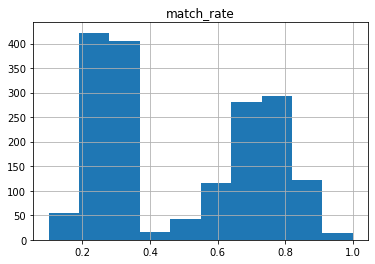

In [434]:
match_rate_df.hist(bins=10);
print('Average agreement (%):', np.round(100*(match_rate_df.match_rate.mean()), 2))